In [43]:
import sys
import os
import numpy as np 
import matplotlib as mpl 
from config.plot_config_2 import *

sys.path.append(os.path.abspath('packages'))
from utilities import *

os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/texlive/2023/bin/x86_64-linux' + ':/usr/bin/pdflatex'


plt.rc('text', usetex=False)
plt.rc('font', family='serif')


### Loading data

In [44]:
t1_data = np.load('data/09_EGFR_MM_stoch.npy', allow_pickle=True)
t1_data = t1_data.item()

In [45]:
alpha_list = t1_data['alpha_list']
beta_list = t1_data['beta_list']
weights_list = t1_data['weights_list']
beta_err_list = t1_data['beta_error_list']
emp_var_list = t1_data['emp_var_list']
epsilon_list = t1_data['epsilon_list']
dt_list = t1_data['dt_list']

In [46]:
netw = make_par('egfr')
dynamics, S, f = get_dynamics()
netw['dynamics'] = dynamics
netw = refresh_netw_par(netw)
rates_par = get_rates_par()

In [47]:
true_weights = get_true_weights(netw['units_subnw'], **rates_par)[0]
pred_weights = np.mean(weights_list, axis=2)[0, 0]

In [48]:
pred_weights.shape

(15,)

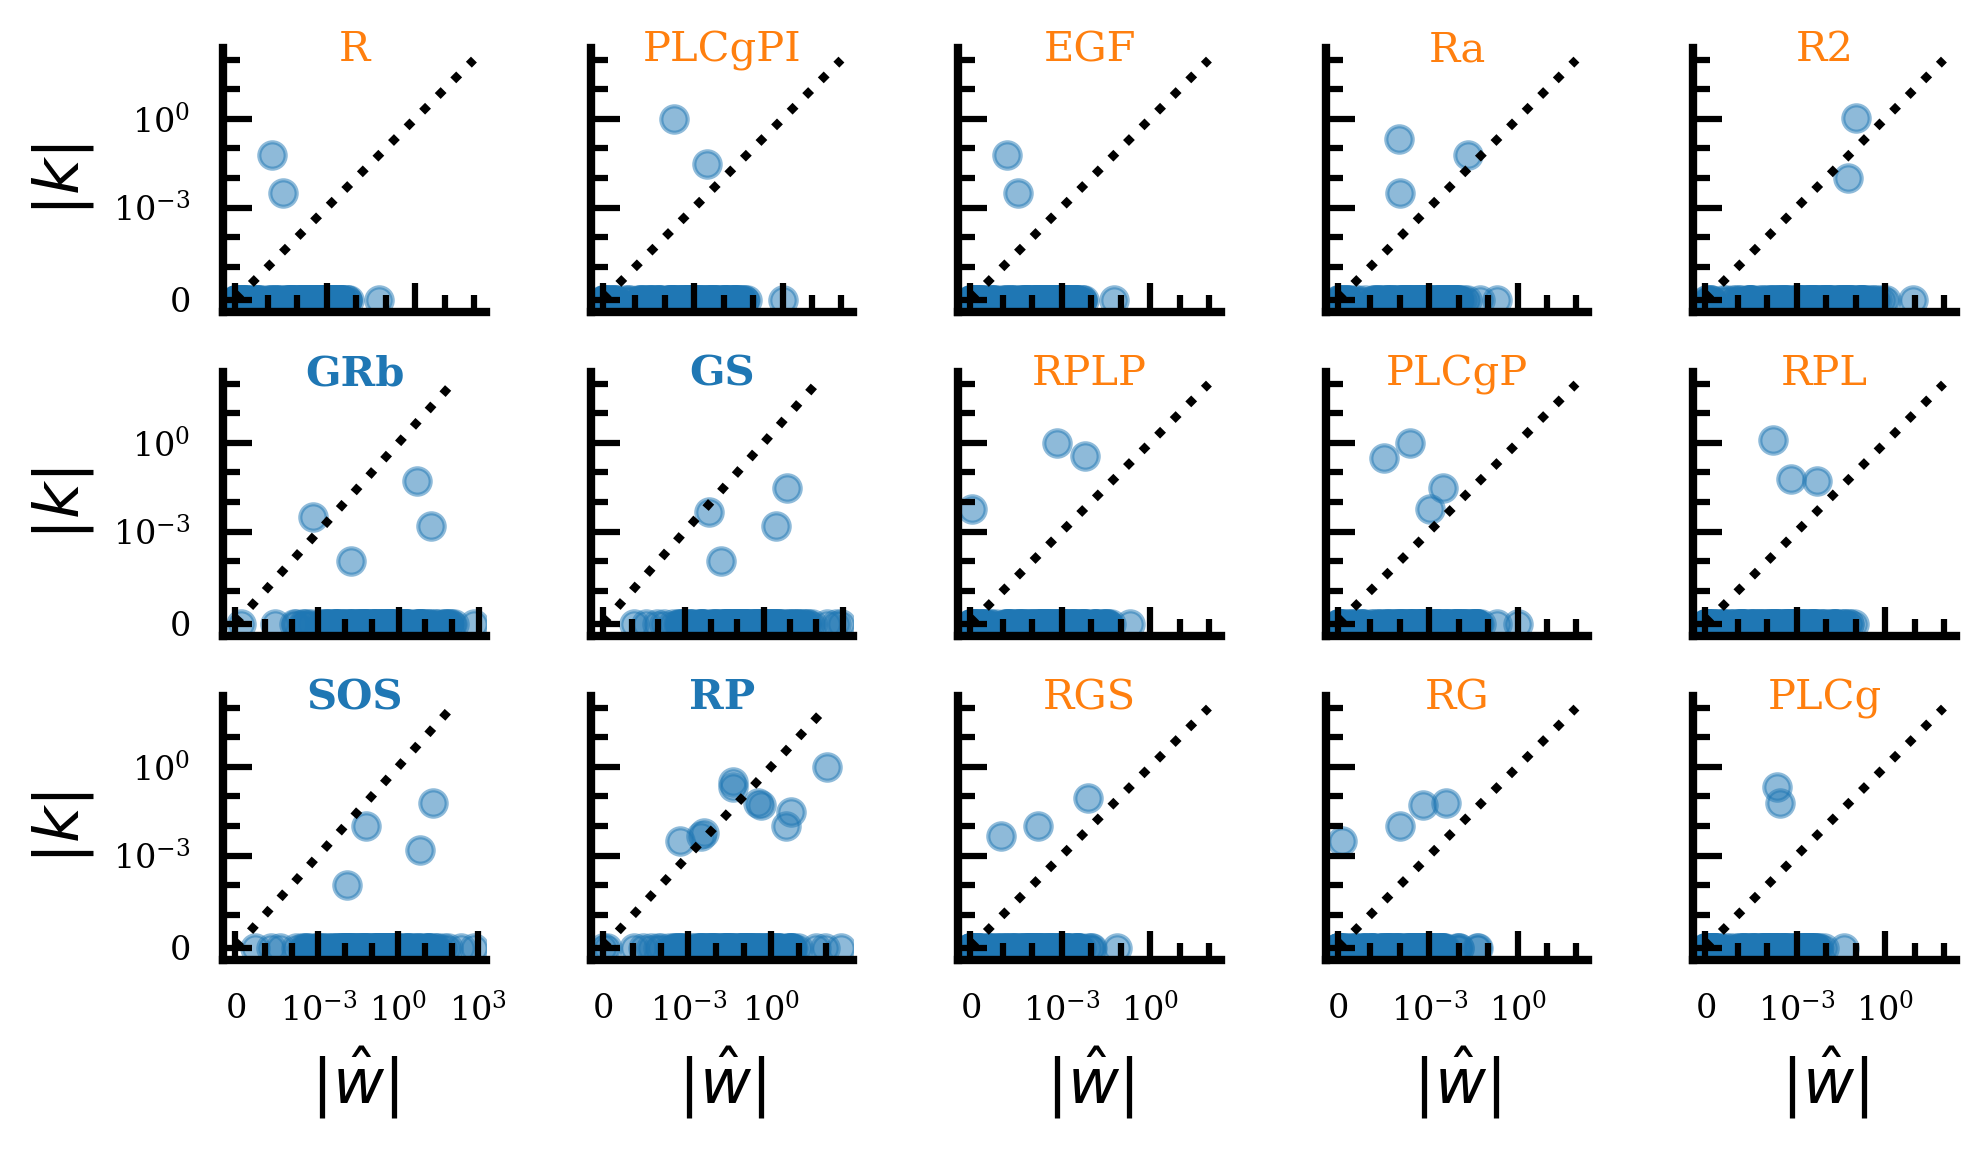

In [49]:
fig = plt.figure(figsize=(7, 4))

fs = 15

u_sub = {unit:idx for idx, unit in enumerate(netw['units_subnw'])}

u2 = ['SOS', 'RP', 'GRb', 'GS', 'PLCg', 'R', 'RPL', 'RPLP', 'PLCgP', 'RG', 'RGS', 'PLCgPI', 'EGF', 'Ra', 'R2',]
u3 = ['SOS', 'RP', 'RGS', 'RG', 'PLCg', 'GRb', 'GS', 'RPLP', 'PLCgP', 'RPL', 'R', 'PLCgPI', 'EGF', 'Ra', 'R2',]# 'ShGS', 'ShP', 'Shc', 'RShGS', 'RShP', 'RSh', 'RShG', 'ShG']

u1 = ['EGF', 'Ra', 'RGS', 'GS', 'GRb', 'PLCgPI', 'SOS', 'RP', 'R2',]

units = u3
linthresh = 1e-5

axes = []
#dx, dy = .2, .2
#sx, sy = .015, .015
#h, w = .1, .14


dx, dy = .125, .22
sx, sy = .05, .05
h, w = .15, .13

for idx, unit in enumerate(units): 
    i_row = idx // 5
    i_col = idx % 5

    axes.append(fig.add_axes([w + (dx + sx) * i_col, h + (dy + sy)*i_row , dx, dy]))
    scale = mpl.scale.SymmetricalLogScale(axes[idx], linthresh=linthresh)
    axes[idx].set_xscale(scale)
    axes[idx].set_yscale(scale)
    axes[idx].xaxis.set_major_locator(mpl.ticker.FixedLocator([0, 1e-3, 1e0, 1e3]))
    axes[idx].yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 1e-3, 1e0, 1e3]))


    axes[idx].xaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', top=False)
    axes[idx].xaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , top=False)
    axes[idx].yaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', right=False)
    axes[idx].yaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , right=False)

    if i_row != 0: 
        axes[idx].xaxis.set_ticklabels([])
    else: axes[idx].set_xlabel(r'$|\hat w|$', fontsize=fs)
    if i_col != 0: 
        axes[idx].yaxis.set_ticklabels([])
    else: axes[idx].set_ylabel(r'$|k|$', fontsize=fs)

for idx, unit in enumerate(units): 
    idx_u = u_sub[unit]
    ax = axes[idx]
    title =  f'{unit}'

    

    weight = 'bold' if unit in netw['units_boundary']  else 'normal'
    color = COLORS(0) if unit in netw['units_boundary']  else COLORS(1)
    ax.set_title(title, fontweight = weight, color=color,  pad=0, y=.95, fontsize=10)

    x_lin = np.linspace(0, 1e2, 2)
    ax.plot(x_lin, x_lin, color='k', lw=2, ls ='dotted')
    ax.scatter(np.abs(pred_weights[idx_u]), np.abs(true_weights[idx_u]), alpha=.5, s=40)


    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)





In [50]:

auc_sin = np.zeros((len(epsilon_list), len(dt_list) ))

for idx_dt, _ in enumerate(dt_list): 
    for idx_eps, _ in enumerate(epsilon_list): 
        auc_sin[idx_eps, idx_dt] = auc_roc(beta_list[ idx_eps, idx_dt], method='single',  beta_error=beta_err_list[idx_eps, idx_dt], num_threshold=1000)

In [51]:
beta_dev = np.abs(emp_var_list/(1/beta_list - emp_var_list))
beta_dev_err =  np.abs(emp_var_list/(1/beta_list - emp_var_list)**2 * 1/beta_list**2) * beta_err_list


beta_dev_mean = np.mean(beta_dev, axis=2)
rel_err = np.mean(beta_err_list/beta_list, axis=2)
beta_dev_mean.shape

(5, 2, 15)

In [52]:
auc_dev =  np.zeros((len(epsilon_list), len(dt_list) ))
 
for idx_dt, _ in enumerate(dt_list): 
    for idx_eps, _ in enumerate(epsilon_list):
        auc_dev[idx_eps, idx_dt] = auc_roc(beta_dev[idx_eps, idx_dt], beta_error=beta_dev_err[idx_eps, idx_dt], num_threshold=1000)
        

In [53]:
# Data Definition



idx_dt1 = 0
idx_dt2 = 1
idx_dt3 = 6

idx_dt_list = [idx_dt1, idx_dt2]

idx_sub_rel = {unit:idx for idx, unit in enumerate(netw['idx_subnw'])}
idx_sub_rel2 = {unit:idx for idx, unit in enumerate(netw['units_subnw'])}

grad_var_mean = np.mean(emp_var_list, axis=2)
beta_list_mean = np.mean(beta_list, axis=2)


<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:59: SyntaxWarning: invalid escape sequence '\,'
<>:113: SyntaxWarning: invalid escape sequence '\,'
<>:115: SyntaxWarning: invalid escape sequence '\,'
<>:151: SyntaxWarning: invalid escape sequence '\e'
<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:59: SyntaxWarning: invalid escape sequence '\,'
<>:113: SyntaxWarning: invalid escape sequence '\,'
<>:115: SyntaxWarning: invalid escape sequence '\,'
<>:151: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_9345/2830058796.py:58: SyntaxWarning: invalid escape sequence '\,'
  ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt1, idx_l],alpha=alpha_m, marker=markers[0],label=s_dt + f':{dt_list[idx_dt1]:.0e}'+ '\,s', color=COLORS(0))
/tmp/ipykernel_9345/2830058796.py:59: SyntaxWarning: invalid escape sequence '\,'
  ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt2, idx_l],alpha=alpha_m, marker=markers[1],label=s_dt + f':{dt_list[idx_dt2]:.0e}' + '\,s', color=COLORS(1))
/tm

Text(-0.38, 0.85, '${(c)}$')

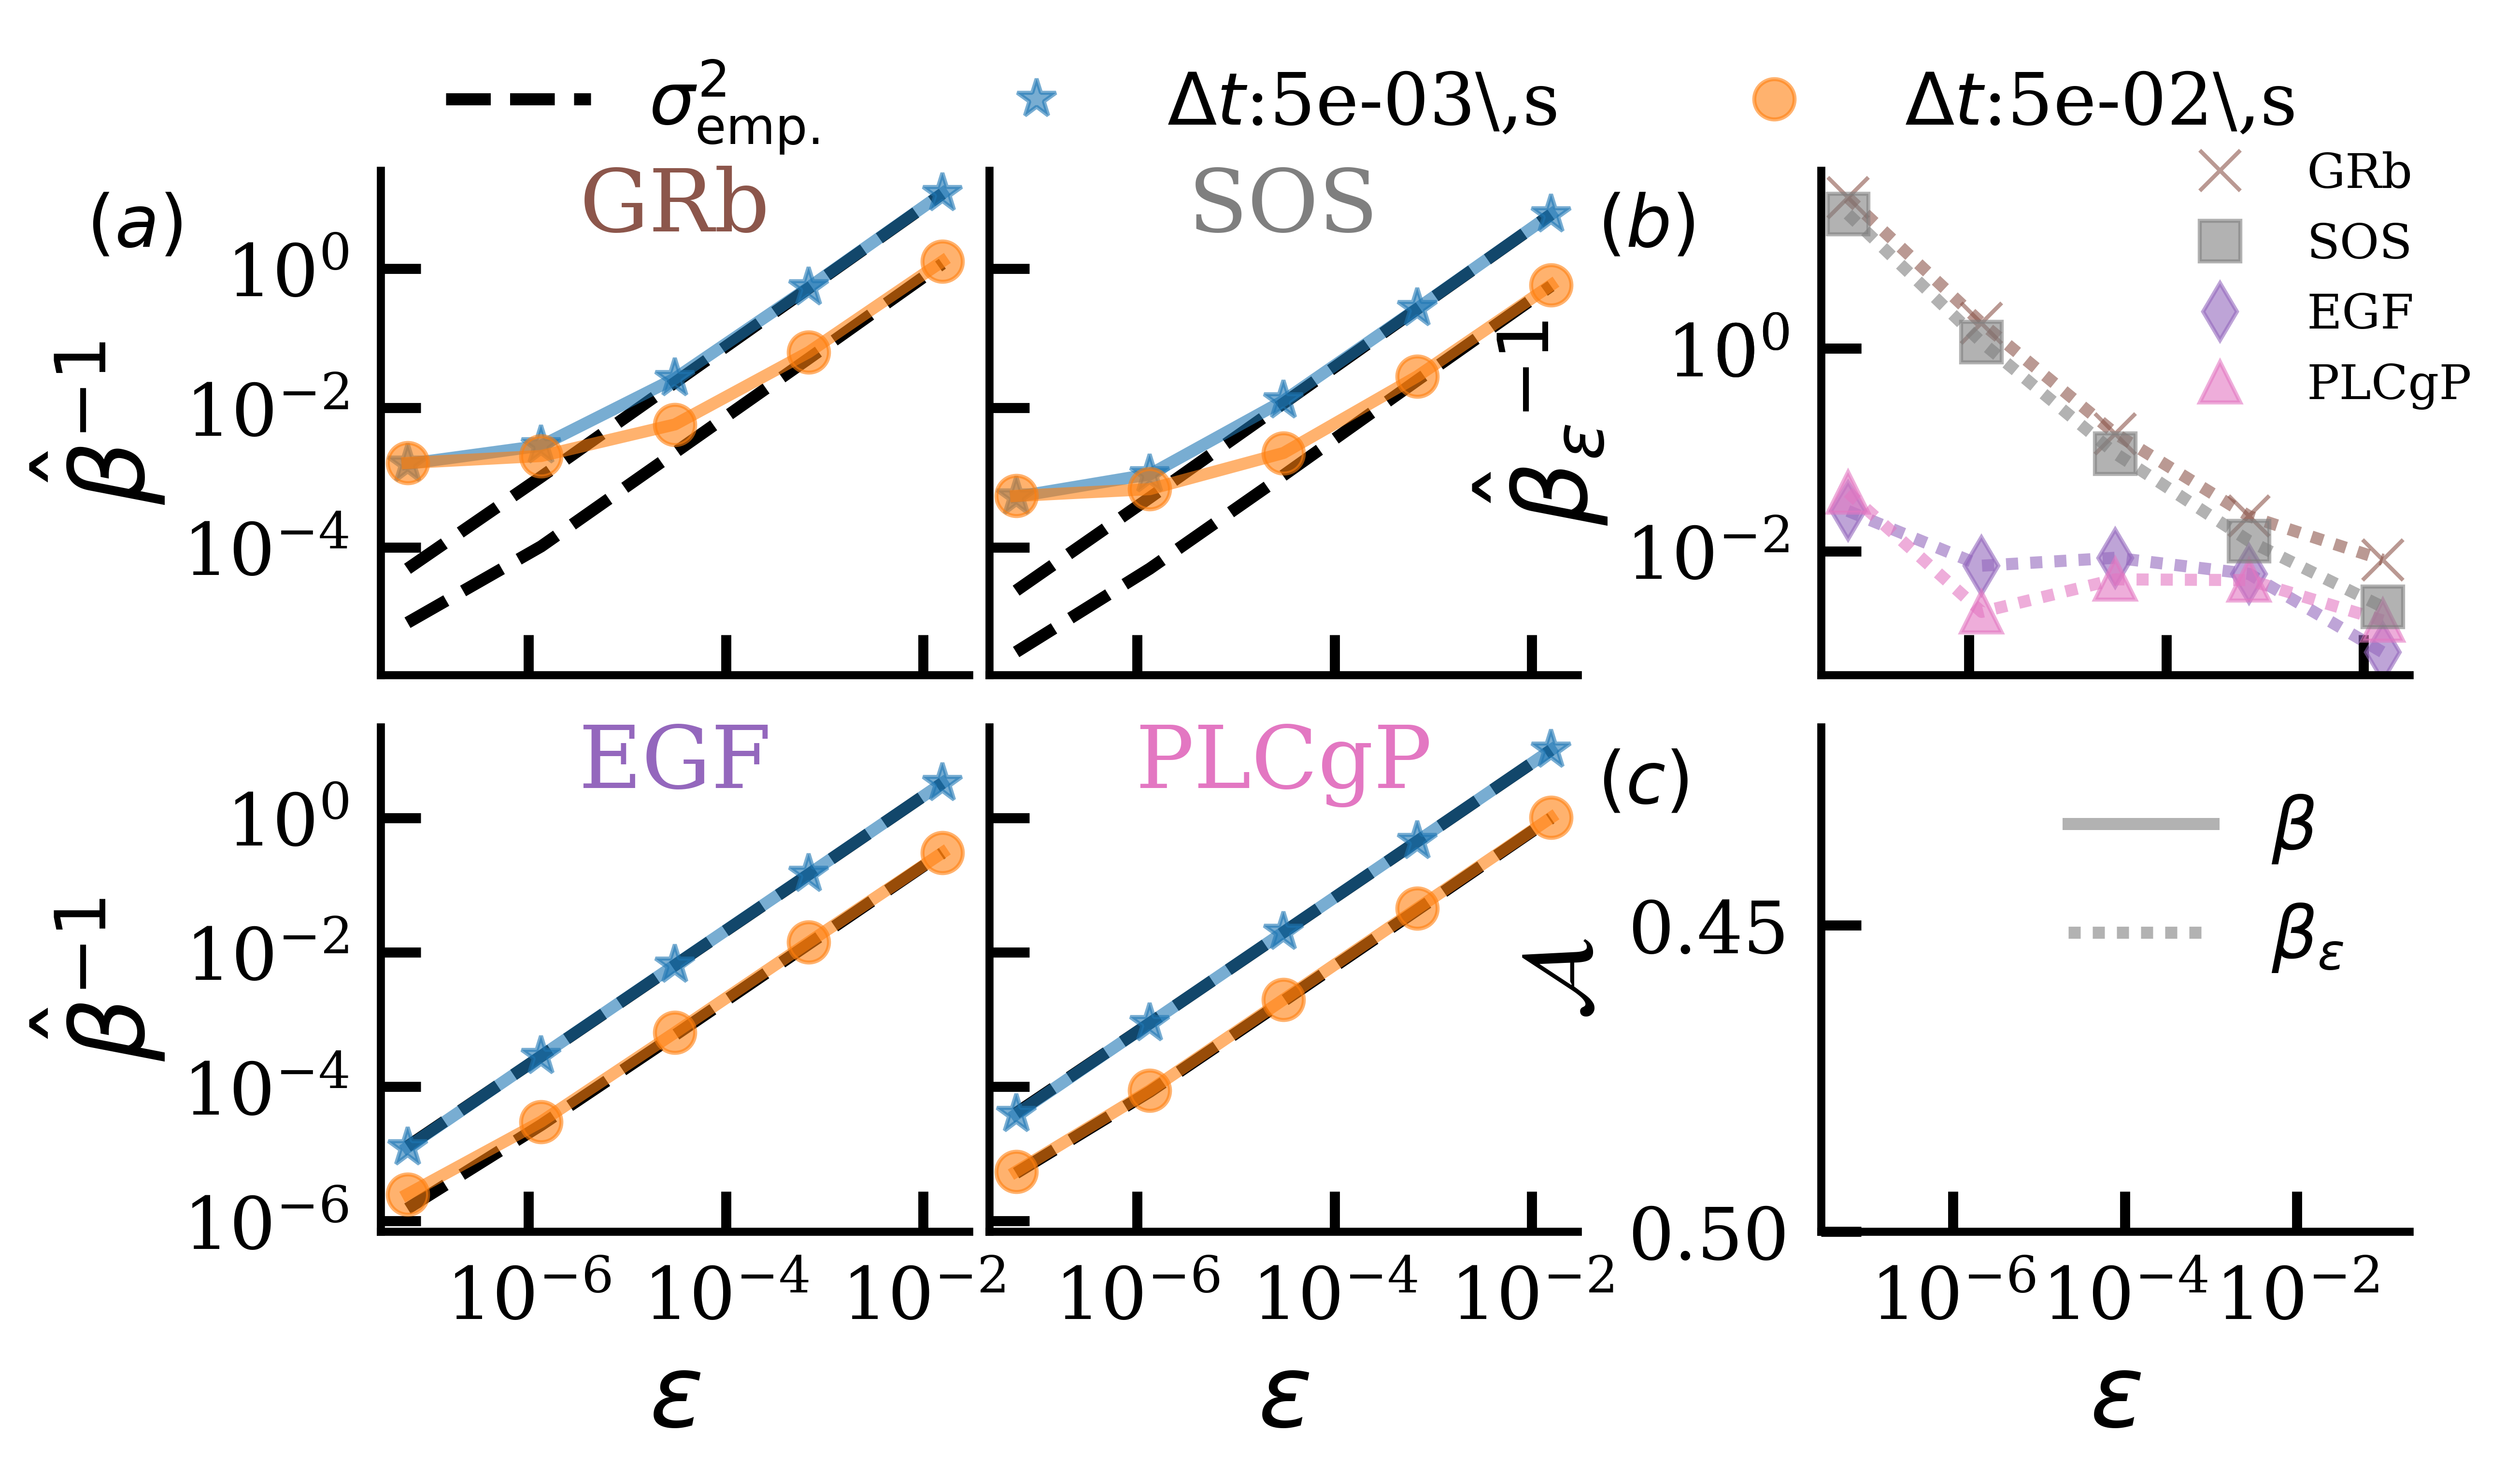

In [54]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(7,6), dpi=600)
#_ax1, _ax2, _ax3, _ax4 = calc_axis(4, .05)

markers= ['*', 'o', 'd']



alpha_m = .6

dx = .29
dy = .29
heig = .32


axEGF = fig.add_axes([0, 0, dx,  dy])
axPL = fig.add_axes([.30, 0, dx, dy], sharey=axEGF)
axGRb = fig.add_axes([0, heig, dx, dy])
axSOS= fig.add_axes([.30, heig, dx, dy], sharey=axGRb)

axBeta= fig.add_axes([.71, heig, dx, dy])
axAUC= fig.add_axes([.71, 0, dx, dy])


axPL.yaxis.set_tick_params(label1On=False)
axSOS.yaxis.set_tick_params(label1On=False)
axGRb.xaxis.set_tick_params(label1On=False)
axSOS.xaxis.set_tick_params(label1On=False)
#axAUC.xaxis.set_tick_params(label1On=True)


#idx_R2 = idx_sub_rel2['R2']
#idx_RP = idx_sub_rel2['RP']

idx_GRb = idx_sub_rel2['GRb']
idx_SOS = idx_sub_rel2['SOS']

idx_PL = idx_sub_rel2['PLCgP']
idx_EGF = idx_sub_rel2['EGF']

pad = -15
y = 1

axEGF.set_title('EGF', color=COLORS(4), y = y, pad=pad)
axGRb.set_title('GRb', color=COLORS(5), y=y , pad=pad)
axPL.set_title('PLCgP', color=COLORS(6),  y=y,  pad=pad )
axSOS.set_title('SOS', color=COLORS(7),   y=y,  pad=pad)



#fig.patch.set_color('white')

for idx, (ax, idx_l) in enumerate(zip([axEGF, axPL, axGRb, axSOS], [idx_EGF, idx_PL, idx_GRb, idx_SOS])): 

    ax.plot(epsilon_list, grad_var_mean[:, idx_dt1, idx_l], '--',  label=s_var_emp, color='k')
    ax.plot(epsilon_list, grad_var_mean[:, idx_dt2, idx_l], '--',   color='k')
    #ax.plot(epsilon_list, grad_var_mean[idx_dt3, :, idx_l], '--',  color=COLORS(7))
    ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt1, idx_l],alpha=alpha_m, marker=markers[0],label=s_dt + f':{dt_list[idx_dt1]:.0e}'+ '\,s', color=COLORS(0))
    ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt2, idx_l],alpha=alpha_m, marker=markers[1],label=s_dt + f':{dt_list[idx_dt2]:.0e}' + '\,s', color=COLORS(1))
    #ax.plot(epsilon_list, 1/beta_list_mean[idx_dt3, :, idx_l],alpha=alpha_m, marker=markers[2], label=r'$dt$' + f': {dt_list[idx_dt3]:.1e} ', color=COLORS(2))
    #a1.set_title('R2', fontweight='normal')
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'$\epsilon$')

    ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))
    #ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_minor_locator(mpl.ticker.NullLocator())
    ax.xaxis.set_minor_locator(mpl.ticker.NullLocator())




#ax1.set_xlabel(r'$\epsilon$')
axEGF.set_ylabel(s_beta_hat + r'$^{-1}$')
axGRb.set_ylabel(s_beta_hat + r'$^{-1}$')





####################################### AUC PLOTS ##########################
#idx_dt = 0
marker_list = ['*', 'o']



for i, idx_dt in enumerate(idx_dt_list): 
    marker = marker_list[i]
    
    axAUC.plot(epsilon_list, auc_dev[:, idx_dt], marker=marker,alpha=alpha_m, color=COLORS(i), label=s_beta_red, ls=(0,(1,1)))
    axAUC.plot(epsilon_list, auc_sin[:, idx_dt], marker=marker,alpha=alpha_m, color=COLORS(i), label=s_beta, ls ='-')

    axAUC.set_ylabel(s_auc)
    axAUC.set_xscale('log')
    axAUC.set_xlabel(r'$\epsilon$')
    axAUC.legend(frameon=True, framealpha=.3)


axAUC.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
axAUC.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
axAUC.xaxis.set_minor_locator(mpl.ticker.NullLocator())
axAUC.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axAUC.xaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))

axAUC.set_ylim(ymin=0.5)

dt1, =  axAUC.plot(0.1, -1, color=COLORS(0), label=s_dt + ':' + f'{dt_list[idx_dt_list[0]]:.0e}\,s', alpha=alpha_m, marker='*', lw=0)

dt2, =  axAUC.plot(0, -1, color=COLORS(1), label=s_dt + ':' + f'{dt_list[idx_dt_list[1]]:.0e}\,s', alpha=alpha_m, marker='o', lw=0)
sigma_emp, = axAUC.plot(0, -1, ls='--', color='k', label=s_var_emp)



beta_red, =  axAUC.plot(0, -1, color='grey', label=s_beta_red, alpha=alpha_m, ls=(0,(1,1)))
beta_norm, = axAUC.plot(0, -1, color='grey', label=s_beta, alpha=alpha_m, ls='-')





######################################## Bottom right ######################
idx_dt = 0

ls = (0,(1,1))

axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_EGF], marker='d', alpha=alpha_m,  label=f'EGF',color=COLORS(4), ls=ls)
axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_GRb], marker='x', alpha=alpha_m,  label=f'GRb', ls=ls,   color=COLORS(5))
axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_PL], marker='^', alpha=alpha_m,  label=f'PLCgP',    color=COLORS(6), ls=ls)
axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_SOS], marker='s', alpha=alpha_m, label=f'SOS', ls=ls,   color=COLORS(7))# plt.plot(dt_list, grad_var_mean   [:, idx_eps, idx_sub1], '--', color='grey', label=label_grad_var)
axBeta.set_ylabel(s_beta_red_hat + r'$^{-1}$')
axBeta.set_xscale('log')
axBeta.set_yscale('log')
axBeta.legend(bbox_to_anchor=(.7,.5))

axBeta.xaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))
axBeta.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
axBeta.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axBeta.xaxis.set_major_formatter(mpl.ticker.NullFormatter())

axBeta.yaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-6, subs=[1, 1e2, 1e4, 1e6]))
axBeta.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-6, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
axBeta.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axBeta.yaxis.set_minor_locator(mpl.ticker.NullLocator())
axBeta.xaxis.set_minor_locator(mpl.ticker.NullLocator())
axBeta.set_xlabel(f'$\epsilon$')


axBeta.set_ylim(ymax=np.max(1/beta_dev_mean[:, idx_dt])*1.6)

lEGF, = axBeta.plot(0, 10**6, marker='d', alpha=alpha_m,  label=f'EGF',color=COLORS(4), lw = 0)
lGRb, = axBeta.plot(0, 10**6, marker='x', alpha=alpha_m,  label=f'GRb',color=COLORS(5), lw=0)
lPL, = axBeta.plot(0, 10**6, marker='^', alpha=alpha_m,  label=f'PLCgP',color=COLORS(6), lw=0)
lSOS,= axBeta.plot(0, 10**6, marker='s', alpha=alpha_m,  label=f'SOS',color=COLORS(7), lw=0)




#

axGRb.set_xlabel('')
axSOS.set_xlabel('')

#### LEGENDS ####
axGRb.legend(handles=[sigma_emp, dt1, dt2], bbox_to_anchor=(0, .9), loc=3, bbox_transform=axGRb.transAxes, ncol=5)
axAUC.legend(handles=[beta_norm, beta_red], bbox_transform=axAUC.transAxes, ncol=1,)
axBeta.legend(handles=[lGRb, lSOS, lEGF, lPL], bbox_to_anchor=(1.18, .44), fontsize=12, loc=4, bbox_transform=axBeta.transAxes, ncols=1, frameon=False, framealpha=.5)


#### Annotation of plots ###
#trans = mpl.transforms.mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans) 
axGRb.text(-.5, .85, r'${(a)}$', transform=axGRb.transAxes, )
axBeta.text(-.38, .85, r'${(b)}$', transform=axBeta.transAxes, )
axAUC.text(-.38, .85, r'${(c)}$', transform=axAUC.transAxes, )



#plt.savefig('../pic_paper/var_predicted.png', transparent=False, bbox_inches='tight')



In [11]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Example plot with LaTeX-rendered text
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]

plt.plot(x, y, label=r'$y = x^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Plot of $y = x^2$')
plt.legend()

plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp4hiqlhlo 7ee3b4a8dc5e9477b958e2751a24b28a.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7ee3b4a8dc5e9477b958e2751a24b28a.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmp4hiqlhlo/7ee3b4a8dc5e9477b958e2751a24b28a.log.




<Figure size 2100x900 with 1 Axes>

In [12]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',    # for math symbols
    r'\usepackage{amssymb}',    # for additional symbols
    r'\usepackage{bm}'          # for bold math symbols
]

ValueError: Key text.latex.preamble: Could not convert ['\\usepackage{amsmath}', '\\usepackage{amssymb}', '\\usepackage{bm}'] to str

In [ ]:
print(mpl.rcParams['text.latex.preamble'])